# Building and evaluating a discrete-time neural network

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.distributions.dirichlet import Dirichlet
import torch.nn.functional as F

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Load the support dataset

In [2]:
def load_support_dataset(random_state=0):

    FILL_VALUES = {
        'alb': 3.5,
        'pafi': 333.3,
        'bili': 1.01,
        'crea': 1.01,
        'bun': 6.51,
        'wblc': 9.,
        'urine': 2502.
    }

    COLUMNS_TO_DROP = [
        'aps', 'sps', 'surv2m', 'surv6m', 'prg2m',
        'prg6m', 'dnr', 'dnrday', 'sfdm2', 'hospdead'
    ]

    df = (
        pd.read_csv('../data/support2.csv')
        .drop(COLUMNS_TO_DROP,axis=1)
        .fillna(value=FILL_VALUES)
        .sample(frac=1, random_state=random_state)
    )

    # one-hot encode categorical variables
    # converts each value of categorical variable to be a separate column with each row value being a True or False
    df = pd.get_dummies(df, dummy_na=True)

    # fill missing values to the median
    df = df.fillna(df.median())

    # standardize numeric columns
    numeric_cols = df.dtypes == 'float64'
    df.loc[:, numeric_cols] = df.loc[:, numeric_cols].transform(
        lambda x: (x - x.mean()) / x.std())
    
    features = (
        df
        .drop(['death', 'd.time'], axis=1)
        .values
        .astype(float)
    )
    
    event_indicator = df['death'].values.astype(float)
    event_time = df['d.time'].values.astype(float)

    return features, event_indicator, event_time

In [6]:
X, s, t = load_support_dataset()

In [7]:
test_idx = len(X) * 4 // 5 ## dividing the data into train and test sets where training on 80% of the data and testing on the rest of the 20%

### defining the train and test set

train_X, train_s, train_t = (arr[:test_idx] for arr in (X, s, t))
test_X, test_s, test_t = (arr[test_idx:] for arr in (X, s, t))

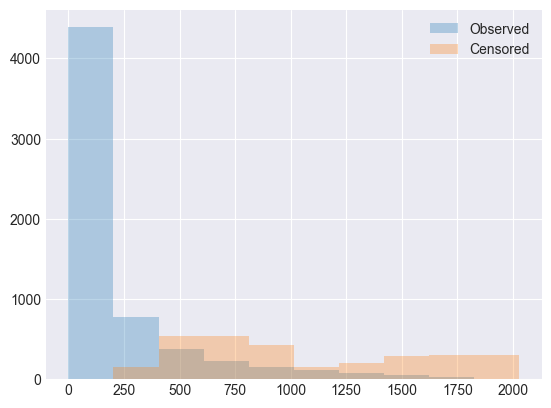

In [8]:
BIN_BOUNDARIES = np.arange(11) * (t.max() / 10)

plt.hist(t[s == 1], alpha=.3, bins=BIN_BOUNDARIES, label='Observed')
plt.hist(t[s == 0], alpha=.3, bins=BIN_BOUNDARIES, label='Censored')
plt.legend()
plt.show()

# Define a Simple NN

In [9]:
class DiscreteTimeNN(torch.nn.Module):

    def __init__(self, hidden_layer_sizes, num_bins):
        super(DiscreteTimeNN, self).__init__()

        self.encoder_layers = [
            torch.nn.LazyLinear(size)
            for size in hidden_layer_sizes
        ]
        
        ### defining the layers in the NN model 
        ## activation layer with ReLU, prediction layer or hidden layers use LazyLinear and output layer uses softmax
        self.activation = torch.nn.ReLU()
        self.prediction_head = torch.nn.LazyLinear(num_bins + 1)
        # self.softmax = torch.nn.Softmax(-1)

    def forward(self, x):
        
        for layer in self.encoder_layers:
            x = layer(x)
            x = self.activation(x)
            
        x = self.prediction_head(x)
        alphas = F.relu(x) + 1

        return alphas

## Define the Negative Log-Likelihood (Loss) for the Discrete Time Failure Time Model

In [10]:
import torch
from torch.distributions import Dirichlet

class EvidentialDiscreteFailureTimeLoss(torch.nn.Module):
    
    def __init__(self, bin_boundaries, tolerance=1e-8, annealing_step=10, kl_scale=0.01):
        super(EvidentialDiscreteFailureTimeLoss, self).__init__()
        
        # Discrete time bin boundaries
        self.bin_starts = torch.tensor(bin_boundaries[:-1])
        self.bin_ends = torch.tensor(bin_boundaries[1:])
        self.bin_lengths = self.bin_ends - self.bin_starts
        
        # Tolerance to avoid log(0) issues
        self.tolerance = tolerance
        
        # Annealing coefficient for KL divergence
        self.annealing_step = annealing_step
        self.kl_scale = kl_scale  # Scale factor for KL divergence term

    def _discretize_times(self, times):
        # Determine which time bins the event times fall into
        return (
            (times[:, None] > self.bin_starts[None, :])
            & (times[:, None] <= self.bin_ends[None, :])
        )

    def _get_proportion_of_bins_completed(self, times):
        # Calculate the proportion of each bin that is completed
        return torch.maximum(
            torch.minimum(
                (times[:, None] - self.bin_starts[None, :]) / self.bin_lengths[None, :],
                torch.tensor(1.0)
            ),
            torch.tensor(0.0)
        )

    def kl_divergence(self, alpha, num_classes, device=None):
        
        if not device:
            device = alpha.device  # Use the device of the input tensor if none is provided
        ones = torch.ones([1, num_classes], dtype=torch.float32, device=device)
        sum_alpha = torch.sum(alpha, dim=1, keepdim=True)
        
        first_term = (
            torch.lgamma(sum_alpha)
            - torch.lgamma(alpha).sum(dim=1, keepdim=True)
            + torch.lgamma(ones).sum(dim=1, keepdim=True)
            - torch.lgamma(ones.sum(dim=1, keepdim=True))
        )

        second_term = ((alpha - ones)
           .mul(torch.digamma(alpha) 
           - torch.digamma(sum_alpha))
           .sum(dim=1, keepdim=True)
        )
        
        kl = first_term + second_term
        return kl

    def forward(self, alphas, event_indicators, event_times, current_epoch):
        """
        alphas: Dirichlet parameters from model (shape: [batch_size, num_bins + 1])
        event_indicators: Binary indicators if the event occurred (1) or was censored (0)
        event_times: Observed time to event or censoring (shape: [batch_size])
        current_epoch: Current epoch number for annealing the KL term
        """
        
        # Dirichlet distribution based on alpha parameters
        dirichlet_dist = Dirichlet(alphas)
        predictions = dirichlet_dist.mean  # Expected probabilities for each bin
        
        # Calculate event and nonevent likelihoods
        event_likelihood = torch.sum(
            self._discretize_times(event_times) * predictions[:, :-1],
            -1
        ) + self.tolerance

        nonevent_likelihood = 1 - torch.sum(
            self._get_proportion_of_bins_completed(event_times) * predictions[:, :-1],
            -1
        ) + self.tolerance

        # Compute negative log-likelihood loss
        log_likelihood = event_indicators * torch.log(event_likelihood) + (1 - event_indicators) * torch.log(nonevent_likelihood)
        nll_loss = -torch.mean(log_likelihood)
        print(f"NLL Loss is: {nll_loss}")
        
        # Calculate KL Divergence term
        kl_loss = torch.mean(self.kl_divergence(alphas, alphas.size(1), alphas.device))
        kl_loss_scaled = self.kl_scale * kl_loss  # Apply scaling to KL divergence
        print(f"Scaled KL Loss is: {kl_loss_scaled}")
        
        # Annealing coefficient to gradually introduce KL term (exponential decay for smoother introduction)
        annealing_coefficient = min(1.0, (current_epoch / self.annealing_step))
        print(f"Annealing coefficient is: {annealing_coefficient}")
        
        # Total evidential loss with scaled KL term
        evidential_loss = nll_loss + annealing_coefficient * kl_loss_scaled
        print(f"Total Loss is: {evidential_loss}")
        
        return evidential_loss


In [12]:
model = DiscreteTimeNN((100, ), 10)
loss_fn = EvidentialDiscreteFailureTimeLoss(BIN_BOUNDARIES)
optimizer = torch.optim.Adam(model.parameters())

/Volumes/Workbench/Academia/Software/Miniconda/envs/dev/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [13]:
def get_batches(*arrs, batch_size=1):
    l = len(arrs[0])
    for ndx in range(0, l, batch_size):
        yield (torch.tensor(arr[ndx:min(ndx + batch_size, l)], dtype=torch.float) for arr in arrs)

NLL Loss is: 1.9947051232793263
Scaled KL Loss is: 0.005384130869060755
Annealing coefficient is: 0.0
Total Loss is: 1.9947051232793263
NLL Loss is: 2.0009283930566686
Scaled KL Loss is: 0.004372028633952141
Annealing coefficient is: 0.0
Total Loss is: 2.0009283930566686
NLL Loss is: 1.9761523763998072
Scaled KL Loss is: 0.0038456686306744814
Annealing coefficient is: 0.0
Total Loss is: 1.9761523763998072
NLL Loss is: 1.8716961295642023
Scaled KL Loss is: 0.004330887459218502
Annealing coefficient is: 0.0
Total Loss is: 1.8716961295642023
NLL Loss is: 1.9415540451891087
Scaled KL Loss is: 0.002111095702275634
Annealing coefficient is: 0.0
Total Loss is: 1.9415540451891087
NLL Loss is: 1.738358043620637
Scaled KL Loss is: 0.002643861807882786
Annealing coefficient is: 0.0
Total Loss is: 1.738358043620637
NLL Loss is: 1.8941808680212509
Scaled KL Loss is: 0.0015955585986375809
Annealing coefficient is: 0.0
Total Loss is: 1.8941808680212509
NLL Loss is: 1.766413321718332
Scaled KL Loss is

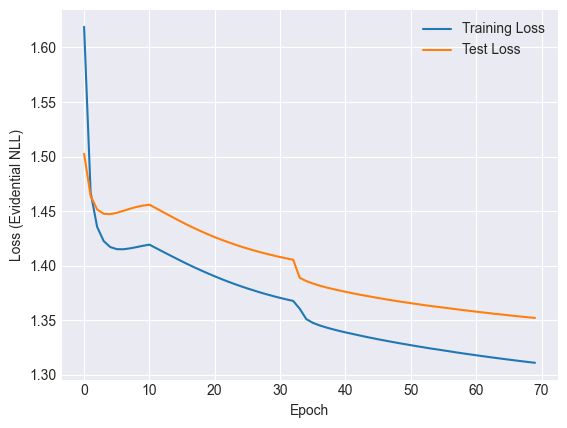

In [14]:
NUM_EPOCHS = 70

train_loss = []
test_loss = []

for epoch_idx in range(NUM_EPOCHS):
    
    epoch_train_loss = []
    epoch_test_loss = []

    for batch_X, batch_s, batch_t in get_batches(train_X, train_s, train_t, batch_size=100):

        optimizer.zero_grad()

        # Make predictions for this batch
        batch_predictions = model(batch_X)
        
        # Compute the loss and its gradients
        loss = loss_fn(batch_predictions, batch_s, batch_t, current_epoch=epoch_idx)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        epoch_train_loss.append(loss.item())

        
    for batch_X, batch_s, batch_t in get_batches(test_X, test_s, test_t, batch_size=100):

        # Make predictions for this batch
        batch_predictions = model(batch_X)
        
        # Compute the loss and its gradients
        loss = loss_fn(batch_predictions, batch_s, batch_t, current_epoch=epoch_idx)
        
        # Gather data and report
        epoch_test_loss.append(loss.item())
        
    train_loss.append(np.mean(epoch_train_loss))
    test_loss.append(np.mean(epoch_test_loss))
            
    print('Completed epoch %i; train loss = %.3f; test loss = %.3f' % (
        epoch_idx, train_loss[-1], test_loss[-1]), end='\r')
          
plt.plot(np.arange(len(train_loss)), train_loss, label='Training Loss')
plt.plot(np.arange(len(test_loss)), test_loss, label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss (Evidential NLL)')
plt.legend()
plt.show()



In [ ]:
dist = Dirichlet(batch_predictions)
kl_divergence = torch.distributions.kl.kl_divergence(dist, Dirichlet(torch.ones_like(batch_predictions)))
kl_loss = torch.mean(kl_divergence)
kl_loss


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Model output (Dirichlet distribution parameters)
test_predictions = (
    model(torch.tensor(test_X, dtype=torch.float))
    .detach()
    .numpy()
)

# Calculate the event probabilities for each bin (mean of Dirichlet distribution)

pred_mean = test_predictions / test_predictions.sum(axis=1, keepdims=True)

# Calculate the 2.5th and 97.5th percentiles 
pred_lower = np.percentile(pred_mean, 2.5, axis=0)
pred_upper = np.percentile(pred_mean, 97.5, axis=0)

# Plot the predicted event probabilities with error bars (95% CI)
plt.bar(
    np.arange(test_predictions.shape[1]),  # Bin positions (e.g., 0 to 10)
    pred_mean.mean(axis=0),                 # Mean predicted probabilities
    yerr=[pred_mean.mean(axis=0) - pred_lower, pred_upper - pred_mean.mean(axis=0)],  # Error bars (95% CI)
    capsize=5
)

plt.xlabel('Bin')
plt.ylabel('Predicted Event Probability')
plt.title('Predicted Event Probability vs. Number of Bins')
plt.show()


In [ ]:
test_predictions.shape

In [ ]:
import sys
sys.path.append('/Volumes/Workbench/Academia/Rotations/EngelhardLab/utils')
from tte_measures import kaplan_meier, xCI, xAUCt, xROCt, xAPt, xPRt

In [ ]:
times = BIN_BOUNDARIES[1:]

cumulative_predicted_risk = np.cumsum(pred_mean, axis=1)[:, :-1]

cp_mean = [0] + list(cumulative_predicted_risk.mean(axis=0))
cp_std = [0] + list(cumulative_predicted_risk.std(axis=0))

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

km_times, km_mean, km_var = kaplan_meier(test_s, test_t)

ax[0].plot(km_times, 1 - km_mean)
ax[0].fill_between(km_times, 1 - km_mean - np.sqrt(km_var), 1 - km_mean + np.sqrt(km_var), alpha=.3)

ax[1].plot([0] + list(times), cp_mean)
ax[1].fill_between(
    [0] + list(times),
    np.array(cp_mean) - np.array(cp_std),
    np.array(cp_mean) + np.array(cp_std),
    alpha=.3
)

plt.show()

In [ ]:
n_bootstrap_samples = 50

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

times = BIN_BOUNDARIES[1:]
time_idx = 6
time = times[time_idx]

cumulative_predicted_risk = np.cumsum(pred_mean, axis=1)[:, :-1]

auct, ci_low, ci_high = xAUCt(
    test_s == 1, test_t, cumulative_predicted_risk, times,
    n_bootstrap_samples=n_bootstrap_samples
)

ax[0].plot(times, auct, 'k-', label='All-All')
ax[0].fill_between(times, ci_low, ci_high, color='k', alpha=.1)

tprt, fprt, _ = xROCt(
    test_s == 1, test_t, cumulative_predicted_risk[:, time_idx], time
)

ax[1].plot(
    fprt, tprt, 'k-',
    label='AUC$_t$ = %.2f (%.2f-%.2f)' % (
        auct[time_idx], ci_low[time_idx], ci_high[time_idx]
    )
)

(apt, prevt), (apt_low, prev_low), (apt_high, prev_high) = xAPt(
    test_s == 1, test_t, cumulative_predicted_risk, times,
    return_prevalence=True,
    n_bootstrap_samples=n_bootstrap_samples
)

ax[2].plot(times, apt, 'k-', label='All')
ax[2].fill_between(times, apt_low, apt_high, color='k', alpha=.1)
ax[2].plot(times, prevt, 'k--')#, label='Prevalence at t')

recallt, precisiont, _, prevt = xPRt(
    test_s == 1, test_t, cumulative_predicted_risk[:, time_idx], time
)

ax[3].plot(
    recallt, precisiont, 'k-',
    label='AP$_t$ = %.2f (%.2f-%.2f)' % (
        apt[time_idx], apt_low[time_idx], apt_high[time_idx]
    )
)

ax[3].plot([0, 1], [prevt, prevt], 'k--')#, label='Prevalence at t')

ax[0].plot(times, times * 0 + .5, 'k--')
ax[0].set_ylim([0.45, 1.])
ax[0].set_ylabel('AUC$_t$')
ax[0].set_xlabel('Time (t)')
ax[0].legend()

ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].set_ylabel('True Positive Rate (t=%i)' % time)
ax[1].set_xlabel('False Positive Rate (t=%i)' % time)
ax[1].legend()

ax[2].set_ylabel('AP$_t$')
ax[2].set_xlabel('Time (t)')
ax[2].legend()

ax[3].set_ylabel('Precision (t=%i)' % time)
ax[3].set_xlabel('Recall (t=%i)' % time)
ax[3].legend()

plt.tight_layout()
plt.show()

In [ ]:
class EvidentialDiscreteFailureTimeNLL(torch.nn.Module):
    
    def __init__(self, bin_boundaries, tolerance=1e-8, annealing_step=10):
        super(EvidentialDiscreteFailureTimeNLL, self).__init__()
        self.bin_starts = torch.tensor(bin_boundaries[:-1])
        self.bin_ends = torch.tensor(bin_boundaries[1:])
        self.bin_lengths = self.bin_ends - self.bin_starts
        self.tolerance = tolerance
        self.annealing_step = annealing_step

    def _discretize_times(self, times):
        return (
            (times[:, None] > self.bin_starts[None, :])
            & (times[:, None] <= self.bin_ends[None, :])
        )

    def _get_proportion_of_bins_completed(self, times):
        return torch.maximum(
            torch.minimum(
                (times[:, None] - self.bin_starts[None, :]) / self.bin_lengths[None, :],
                torch.tensor(1.0)
            ),
            torch.tensor(0.0)
        )

    
    def forward(self, alphas, event_indicators, event_times, current_epoch):
        dirichlet_dist = Dirichlet(alphas)
        predictions = dirichlet_dist.mean  # Expected probabilities for each bin
        event_likelihood = torch.sum(
            self._discretize_times(event_times) * predictions[:, :-1],
            -1
        ) + self.tolerance

        nonevent_likelihood = 1 - torch.sum(
            self._get_proportion_of_bins_completed(event_times) * predictions[:, :-1],
            -1
        ) + self.tolerance
        
        log_likelihood = event_indicators * torch.log(event_likelihood)
        log_likelihood += (1 - event_indicators) * torch.log(nonevent_likelihood)
        nll_loss = -torch.mean(log_likelihood)
        kl_divergence = torch.distributions.kl.kl_divergence(dirichlet_dist, Dirichlet(torch.ones_like(alphas)))
        kl_loss = torch.mean(kl_divergence)
        annealing_coefficient = min(1.0, current_epoch / self.annealing_step)
        evidential_loss = nll_loss + annealing_coefficient * kl_loss
        
        return evidential_loss 
